In [1]:
from sklearn.ensemble import RandomForestClassifier

from auto_mod import AutoModeling, ModelComparison
from auto_mod_metrics import gini_score

In [2]:
# let' screate a dataset for binary classification 
X_train, y_train, X_oos, y_oos, X_oot, y_oot = AutoModeling.generate_data(n_features=100,  # overall number of features
                                                                          n_informative=10,  # number of significant features
                                                                          n_train=10000,  # observations in train sample
                                                                          n_oos=2000,  # observations in out-of-sample sample
                                                                          n_oot=3000,  # observations in out-of-time sample
                                                                          n_cat_features=15,  # number of cat features
                                                                          label_list_cat=['Z', 'Y', 'X'],  # values of cat features
                                                                          noise=0.01, bias = 2,
                                                                          model_type='binary')

In [3]:
# train a baseline model using all features
X_train_rf, X_oos_rf, X_oot_rf = AutoModeling.encode_cat_feats(X_train, X_oos, X_oot)

baseline = RandomForestClassifier()
baseline.fit(X_train_rf, y_train)
pred = baseline.predict(X_oos_rf)
print('Gini for OOS = {}'.format(round(gini_score(y_oos, pred), 3)))

Gini for OOS = 0.797


Solving binary problem, key performance metric is gini.

LGBM feature importance calculation is in process...
Fast feature selection is finished! 19 features out of 100 are selected.


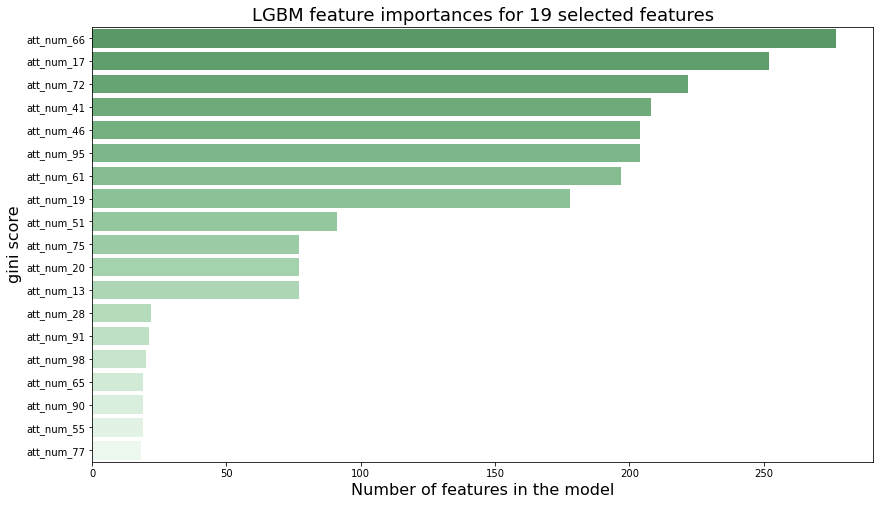


Stepwise forward feature selection is in process...
1 feature out of 19 is selected, gini = 0.539
2 features out of 19 are selected, gini = 0.726
3 features out of 19 are selected, gini = 0.792
4 features out of 19 are selected, gini = 0.865
5 features out of 19 are selected, gini = 0.903
6 features out of 19 are selected, gini = 0.933
7 features out of 19 are selected, gini = 0.949
8 features out of 19 are selected, gini = 0.962
9 features out of 19 are selected, gini = 0.964
10 features out of 19 are selected, gini = 0.966
Forward feature selection is finished! 10 features out of 19 are selected.


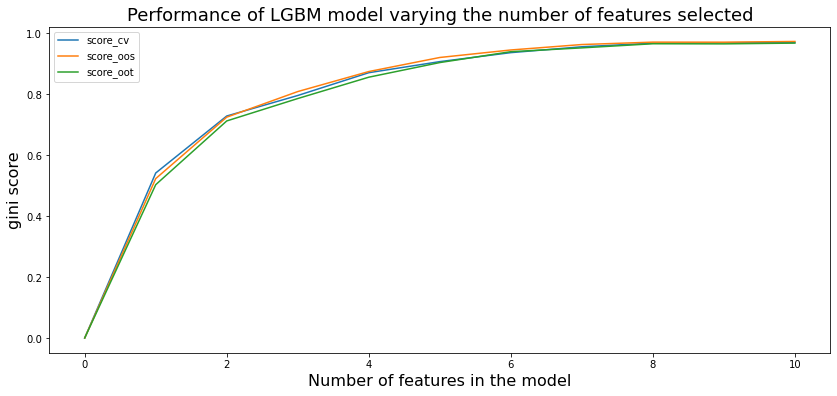


Hyperparameters tuning for LGBM model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

LGBM model best_params: {'reg_lambda': 0.99, 'reg_alpha': 0.3126315789473684, 'num_leaves': 200, 'min_child_samples': 45, 'max_depth': 36, 'learning_rate': 0.26366508987303583}


In [4]:
# train an auto model with feature selection
model = AutoModeling(X_train=X_train, y_train=y_train,
                     X_oos=X_oos, y_oos=y_oos,
                     X_oot=X_oot, y_oot=y_oot,
                     metric='gini')

result = model.modeling(n_iter_lgbm=100)

In [5]:
result.get('mod_result')

,num_feats,score_cv,score_train,score_oos,score_oot
LGBM,10,0.975417,1.000000,0.976624,0.971979
LR,10,0.834490,0.836532,0.835890,0.816713


In [6]:
# compare two models using Gini metric 
best_model = result.get('best_model_lgbm')

mod_com = ModelComparison(X_train_rf, y_train, baseline, 
                          X_train, y_train, best_model,
                          metric='gini')

Calculating statistics for alternative model...



Calculating statistics for initial model...


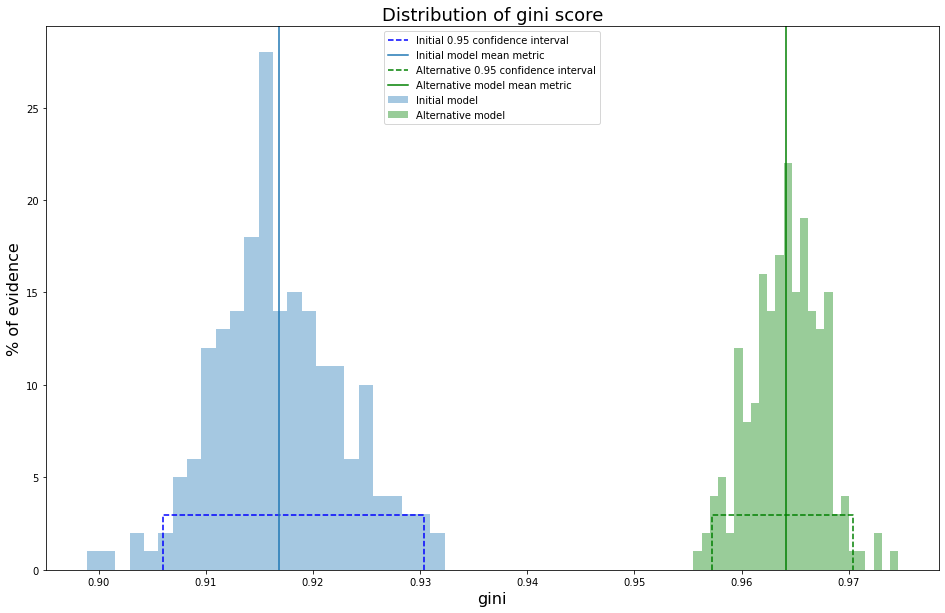


Mean value of gini metric for initial model is 0.9168, and 0.9641 for the alternative one.


In [7]:
# launch model comparison for train sample using splitting

stats, summary = mod_com.compare_models(n_iter=200, 
                                        hist_bins=25, 
                                        bootstrap=False)

In [8]:
stats

,mean,std,left bound,right bound
Alternative model,0.964119,0.003298,0.957202,0.970404
Initial model,0.916848,0.005969,0.906039,0.930395
Absolute difference (p.p.),4.727106,0.467444,3.791095,5.632961
Relative difference (%%),5.158813,0.537849,4.112386,6.245621
